In [2]:
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as T

sns.set()

# Introduction to Bayesian Machine Learning with PyMC3
## Dhruv Patel

## Bayesian Linear Regression

- Our model is $y = w^{T}\phi(x) + \epsilon$. 
    - Where $\phi(x)$ is feature vector for input $x$.
    - and $\epsilon$ is gaussian additive noise. $\epsilon \sim \mathcal{N}(0, \beta^{-1})$

- Then likelyhood is given by
    
    $p(D|w) = \prod_{n=0}^N \mathcal{N}(t_n|w^T\phi(x_n), \beta^{-1})$

- Bayes theorem:
    
    $p(w|D) = \frac{p(D|w)p(w)}{p(D)}$

- Q: What should be our prior $p(w)$?

### Conjugate prior

- For analytic tractability, let us assume that prior is also normal (i.e. conjugate prior)

    $ w \sim \mathcal{N}(m_0, S_0) $

    In this case it can be (by tedious algebra) shown that posterior is also gaussian with following form.

    $ p(w|D) = \mathcal{N}(w|m_N, S_N) $

    $ S_N^{-1} = S_0^{-1} + \beta \Phi^T\Phi $

    $ m_N = S_N(S_0^{-1}m_0 + \beta \Phi^T t) $ 

- Predictive distribution for new input $x_0$,
    is given by $p(t_0|x_0, D, \alpha, \beta) = \int p(y|w, \beta)p(w|D, \alpha, \beta)$
   
    $p(t_0|x_0, D, \alpha, \beta) = \mathcal{N}(m_N^T \phi(x_0), \sigma_N^2(x))$
    
    Where $\sigma_N^2(x) = \frac{1}{\beta} + \phi(x_0)^TS_N\phi(x)$

#### Demo

In [9]:
def posterior_gaussian(phi, t, m_0, S_0, beta):
    S_0_inv = np.linalg.inv(S_0)
    S_N = np.linalg.inv(S_0_inv + beta * (phi.T @ phi))
    m_N = np.matmul(S_N, beta * (phi.T @ t))
    return m_N, S_N

def predictive_dist(phi, beta, m_N, S_N):
    return phi @ m_N,  1/beta + (phi.T * (S_N @ phi.T)).sum(0)

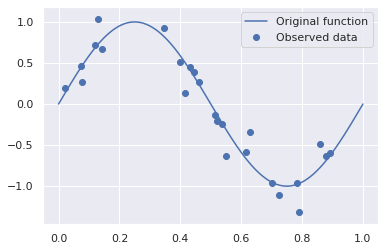

In [15]:
D, N = 4, 25
noise_std = 0.2
beta = 1/noise_std**2

x = np.random.uniform(0, 1, N)
t = np.sin(2*np.pi*x) + np.random.normal(scale=noise_std, size=N)

grid_x = np.linspace(0, 1, 1000)
grid_y = np.sin(2*np.pi*grid_x)
phi, phi_grid = np.empty((N, D)), np.empty((len(grid_x), D))
for i in range(D):
    phi[:, i] = np.power(x, i)
    phi_grid[:, i] = np.power(grid_x, i)
    
plt.plot(grid_x, grid_y, label="Original function")
plt.scatter(x, t, label="Observed data")
plt.legend()

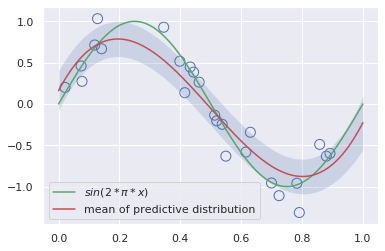

In [82]:
m_0, S_0 = np.zeros(D), np.eye(D)*50
m_N, S_N = posterior_gaussian(phi, t, m_0, S_0, beta)
plt.scatter(x, t, marker='o', s=100, facecolors='none', edgecolors='b')
predictive_mean, predictive_var = predictive_dist(phi_grid, beta, m_N, S_N)
predictive_std = np.sqrt(predictive_var) 
plt.plot(grid_x, np.sin(2*np.pi*grid_x), 'g', label='$sin(2*\pi*x)$')
plt.plot(grid_x, predictive_mean, 'r', label='mean of predictive distribution')
plt.fill_between(grid_x, predictive_mean - predictive_std, predictive_mean + predictive_std, alpha=0.2)
plt.legend()

#### Same thing but without much math

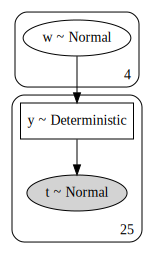

In [83]:
# import pymc3 as pm
with pm.Model() as linreg:
    w = pm.Normal("w", mu=np.zeros(D), sigma=np.ones(D)*np.sqrt(50), shape=(D, ))
#     w = pm.MvNormal("w", mu=np.zeros(D), cov=np.eye(D)*50)
    y = pm.Deterministic("y", T.dot(phi, w))
    t_obs = pm.Normal("t", mu=y, tau=beta, observed=t)
pm.model_to_graphviz(linreg)

In [84]:
with linreg:
    trace = pm.sample(15000, tune=1000)
burned_trace = trace[5000:]
w_samples = burned_trace['w']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]
Sampling 4 chains, 0 divergences: 100%|██████████| 64000/64000 [02:27<00:00, 433.57draws/s]
The acceptance probability does not match the target. It is 0.5683138306674322, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


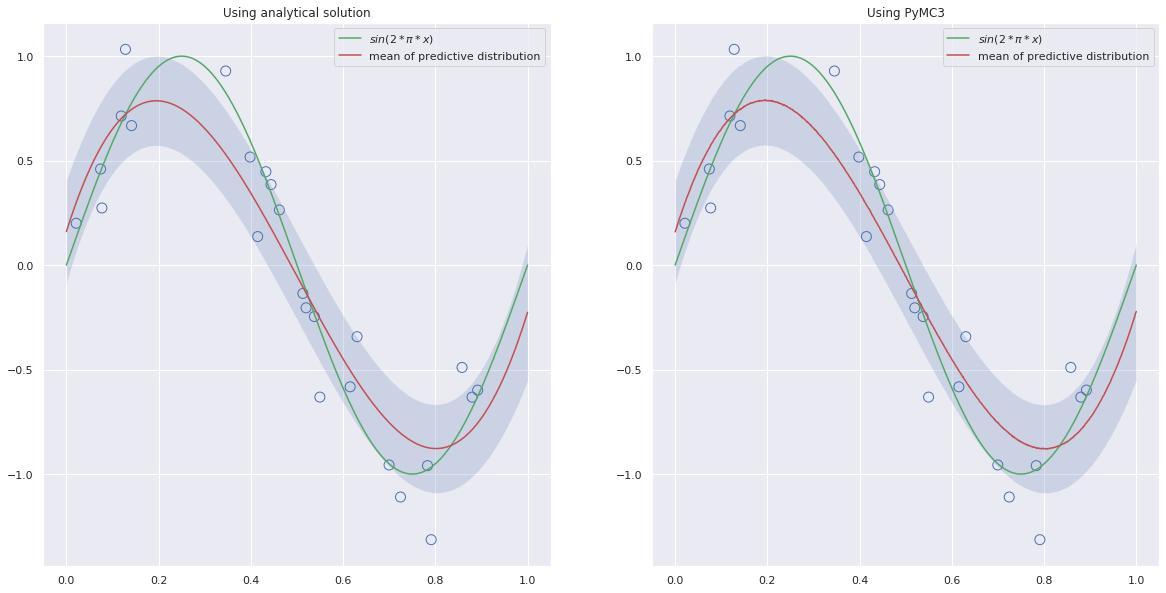

In [85]:
def plot_figure(mean, std , title):
    plt.scatter(x, t, marker='o', s=100, facecolors='none', edgecolors='b')
    plt.plot(grid_x, np.sin(2*np.pi*grid_x), 'g', label='$sin(2*\pi*x)$')
    plt.plot(grid_x, mean, 'r', label='mean of predictive distribution')
    plt.fill_between(grid_x, mean - std, mean + std, alpha=0.2)
    plt.legend(); plt.title(title)
plt.figure(figsize=(20, 10))
plt.subplot(121); plot_figure(predictive_mean, predictive_std, "Using analytical solution")
grid_pred_samples = np.dot(w_samples, phi_grid.T) + np.random.normal(0, noise_std, size=(len(w_samples), len(grid_x)))
plt.subplot(122); plot_figure(grid_pred_samples.mean(axis=0), grid_pred_samples.std(axis=0), "Using PyMC3")

#### With unknown $\beta$

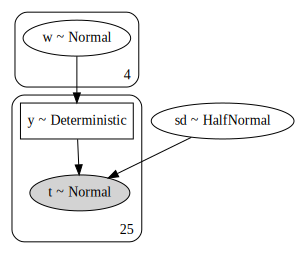

In [86]:
with pm.Model() as linreg2:
    w = pm.Normal("w", mu=np.zeros(D), sigma=np.ones(D)*np.sqrt(50), shape=(D, ))
    sigma = pm.HalfNormal("sd", sd=1)
    y = pm.Deterministic("y", T.dot(phi, w))
    t_obs = pm.Normal("t", mu=y, sd=sigma, observed=t)
pm.model_to_graphviz(linreg2)

In [87]:
with linreg2:
    trace = pm.sample(5000, target_accept=0.95)
burned_trace = trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, w]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [02:01<00:00, 180.44draws/s]
The number of effective samples is smaller than 25% for some parameters.


/home/dhruv/.local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6f258c1c0>,
      dtype=object)

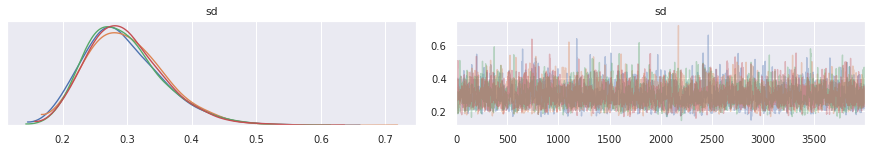

In [91]:
pm.plot_trace(data=burned_trace, var_names=['sd'])

## Monte Carlo methods

## Politician's random walk
[Doing Bayesian Data Analysis (John Kruschke)](https://sites.google.com/site/doingbayesiandataanalysis/)

- We have system of say 7 islands aranged in a line with different populations.
- Politician doesn't know population of individual island, but wants to spend his time such that he spends his time proportional to island's population.
- He can ask population of current island and of either of left island or right island.
- His algorithm
    - Toss a fair coin. If heads, *thinks* of going left else *thinks* of going right
    - Ask population of proposed island.
        - if more than population of current island, definitely go
        - else go there with probability $\frac{P_{\text{next}}}{P_{\text{current}}}$

<BarContainer object of 7 artists>

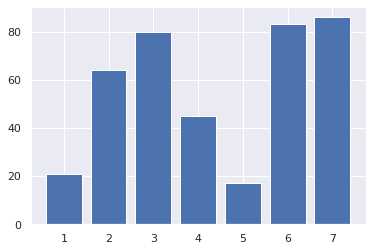

In [4]:
N_islands = 7
population = np.random.randint(10, 100, N_islands+2)
population[0] = population[-1] = 0
plt.bar(np.arange(1, N_islands+1), population[1:-1])

In [5]:
calendar = [1 + np.random.randint(N_islands)]
for i in range(1, 10000):
    proposed = calendar[i-1] + np.random.choice([-1, 1])
    if population[proposed] > population[calendar[i-1]]:
        calendar.append(proposed)
    else:
        prob = population[proposed]/population[calendar[i-1]]
        if np.random.rand() < prob:
            calendar.append(proposed)
        else:
            calendar.append(calendar[-1])

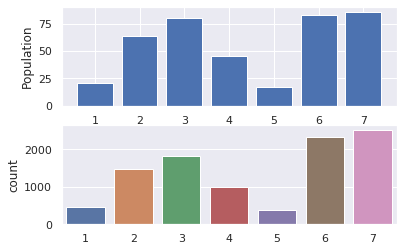

In [6]:
plt.subplot(211)
plt.bar(np.arange(1, N_islands+1), population[1:-1])
plt.xlabel("Island"); plt.ylabel("Population")
plt.subplot(212)
sns.countplot(calendar)

## Metropolis algorithm
- We have an (unnormalized) target distribution $\tilde{P}$ to draw samples from. 
- We have a proposal distribution from which we can sample next candidate.
    - This distribution can be anything. You can have 2d-gaussian for bivariate target distribution.
- We initialize with any state. 
- For each iteration
    - propose new candidate. ($S_\text{current})$
    - calculate $p = \frac{\tilde{P}(S_\text{current})}{\tilde{P}(S_\text{prev})}$
    - if $p > 1, S_\text{prev} = S_\text{current}$
    - else with probability $p, S_\text{prev} = S_\text{current}$
    
[In Action](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana)

### Limitations
- sensitive to proposal distribution.
    - if proposal distribution has high variance then most samples are rejected (see in action by varing $\sigma$
    - if proposal distribution has low variance then effective sample size is small
    
If we have multivariate target distribution($P(x_1, x_2, \dots , x_n)$ and we can sample from $P(x_i | x_{-i})$ Gibbs sampling works better.
- Here we randomly choose one variable to update.
- sample this variable from univariate distribution conditioned on all other variables to current state.
- No rejections!
- [Gibbs sampling in action](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=GibbsSampling&target=banana)